## TPE Tuning

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

In [29]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,87.18412,2,25.0,0.576119,41.516993,0.611460,79.814266,8.965251,277.740071,...,368.245672,0.175542,216.250128,33.930873,496.754841,2.455708,8151.153118,2.497000,2210.0,5354.20
1,1,83.02190,1,29.0,0.104620,190.636798,0.559982,222.087675,41.537126,697.713902,...,267.444573,0.407987,227.356779,27.734884,641.982542,2.747380,-2338.896143,2.685500,1223.0,2944.30
2,0,87.32600,0,30.0,0.110000,NaN,NaN,149.860000,50.100000,NaN,...,232.310000,0.455000,214.970000,37.595000,627.575000,3.295000,NaN,2.761275,1932.0,3385.85
3,0,85.15340,0,29.0,0.227405,NaN,0.502037,236.747564,29.247323,710.169115,...,236.821140,0.502037,236.747564,29.247323,710.169115,2.923999,-1418.526557,2.956000,2180.0,3478.40
4,1,71.72600,2,22.0,0.150000,185.770000,0.550000,205.680000,31.490000,636.960000,...,272.700000,0.395000,223.495000,31.255000,621.290000,3.030000,1717.020000,2.426235,1275.0,3018.85


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((875, 22), (376, 22))

In [31]:
imputer_nonLin = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_knn = imputer_nonLin.transform(X_train)
X_test_knn = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [32]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [33]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [34]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((875, 22), (376, 22))

## TPE

In [35]:
def objective(trial):
    
    
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 300)
    rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 20)
    rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 0.2)
    rf_max_features = trial.suggest_categorical("rf_max_features", ["sqrt", "log2", None])
    rf_min_samples_leaf = trial.suggest_float("rf_min_samples_leaf", 0.005, 0.05)
    rf_class_weight = trial.suggest_categorical("rf_class_weight", ["balanced", "balanced_subsample"])
        
    model = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                   criterion=rf_criterion,
                                   max_depth=rf_max_depth,
                                   min_samples_split=rf_min_samples_split,
                                   max_features=rf_max_features,
                                   min_samples_leaf=rf_min_samples_leaf,
                                   random_state=42, 
                                   class_weight=rf_class_weight)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [36]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-08-30 18:34:58,221] A new study created in memory with name: no-name-4c14d3d9-4253-4b3e-9c03-2b8f961c4e06


[I 2025-08-30 18:35:06,920] Trial 0 finished with value: 0.7104081218632302 and parameters: {'rf_n_estimators': 112, 'rf_criterion': 'entropy', 'rf_max_depth': 11, 'rf_min_samples_split': 0.0960928246256406, 'rf_max_features': 'sqrt', 'rf_min_samples_leaf': 0.009229760540884837, 'rf_class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7104081218632302.
[I 2025-08-30 18:35:15,627] Trial 1 finished with value: 0.7049500321946142 and parameters: {'rf_n_estimators': 143, 'rf_criterion': 'entropy', 'rf_max_depth': 18, 'rf_min_samples_split': 0.11851283086945273, 'rf_max_features': 'sqrt', 'rf_min_samples_leaf': 0.021060649793541414, 'rf_class_weight': 'balanced'}. Best is trial 0 with value: 0.7104081218632302.
[I 2025-08-30 18:35:53,355] Trial 2 finished with value: 0.707261649599111 and parameters: {'rf_n_estimators': 162, 'rf_criterion': 'entropy', 'rf_max_depth': 8, 'rf_min_samples_split': 0.11280416959126051, 'rf_max_features': 'sqrt', 'rf_min_samples_leaf': 0.0301997641

In [37]:
study.best_params

{'rf_n_estimators': 208,
 'rf_criterion': 'entropy',
 'rf_max_depth': 16,
 'rf_min_samples_split': 0.0892849084438209,
 'rf_max_features': None,
 'rf_min_samples_leaf': 0.023533046023203115,
 'rf_class_weight': 'balanced'}

In [38]:
study.best_value

0.7219174759422439

In [39]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_rf_class_weight,params_rf_criterion,params_rf_max_depth,params_rf_max_features,params_rf_min_samples_leaf,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.710408,2025-08-30 18:34:58.226458,2025-08-30 18:35:06.920367,0 days 00:00:08.693909,balanced_subsample,entropy,11,sqrt,0.009230,0.096093,112,COMPLETE
1,1,0.704950,2025-08-30 18:35:06.923285,2025-08-30 18:35:15.626729,0 days 00:00:08.703444,balanced,entropy,18,sqrt,0.021061,0.118513,143,COMPLETE
2,2,0.707262,2025-08-30 18:35:15.629850,2025-08-30 18:35:53.355979,0 days 00:00:37.726129,balanced_subsample,entropy,8,sqrt,0.030200,0.112804,162,COMPLETE
3,3,0.714463,2025-08-30 18:35:53.355979,2025-08-30 18:36:07.061993,0 days 00:00:13.706014,balanced,gini,5,log2,0.022986,0.183095,225,COMPLETE
4,4,0.715116,2025-08-30 18:36:07.061993,2025-08-30 18:36:22.446587,0 days 00:00:15.384594,balanced_subsample,gini,17,sqrt,0.013720,0.171784,220,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_18156\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


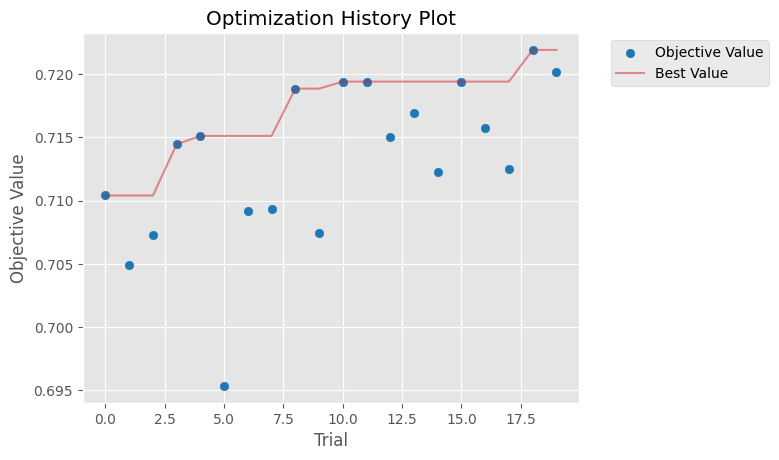

In [40]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_18156\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

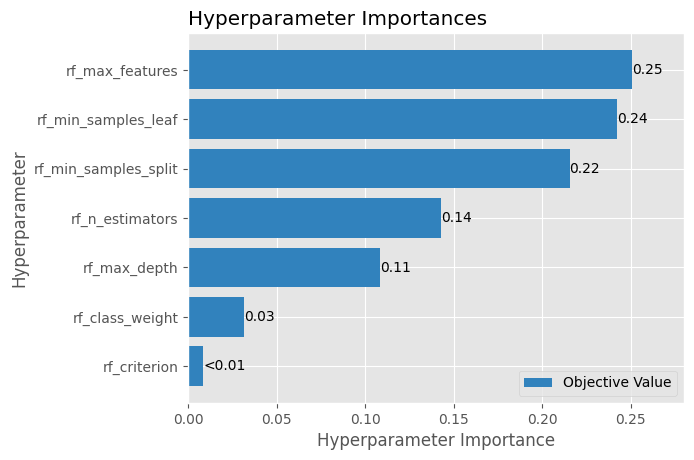

In [41]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_18156\3879122787.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='rf_class_weight', ylabel='Objective Value'>,
       <Axes: xlabel='rf_criterion'>, <Axes: xlabel='rf_max_depth'>,
       <Axes: xlabel='rf_max_features'>,
       <Axes: xlabel='rf_min_samples_leaf'>,
       <Axes: xlabel='rf_min_samples_split'>,
       <Axes: xlabel='rf_n_estimators'>], dtype=object)

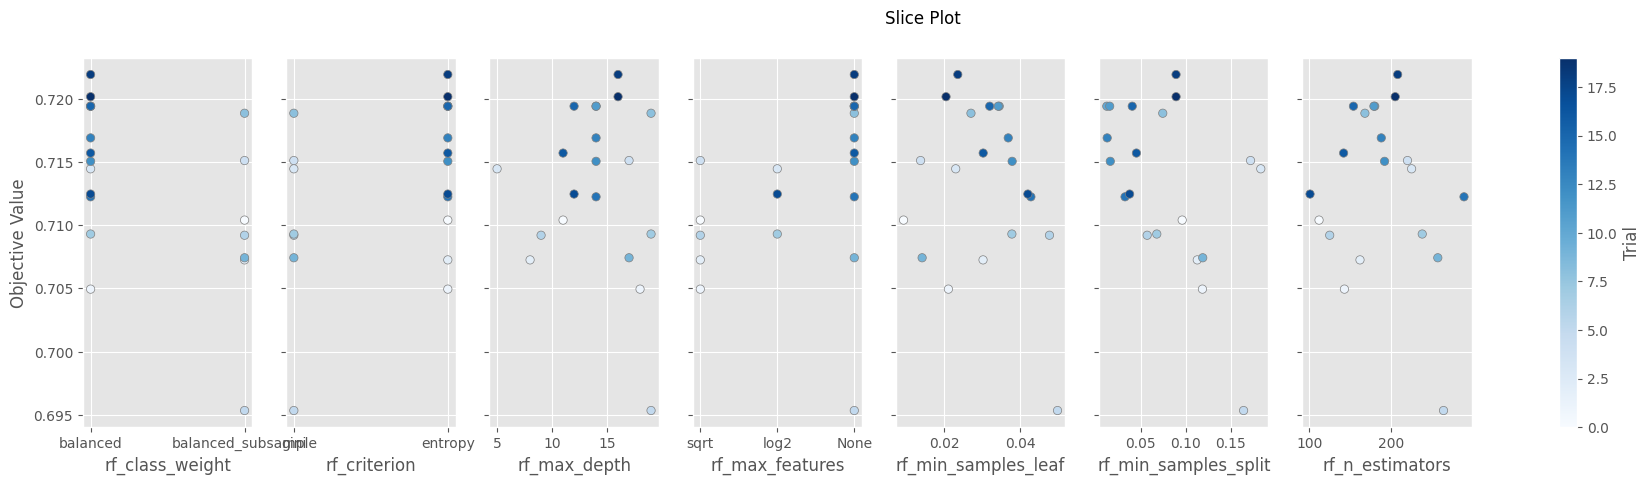

In [42]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["rf_n_estimators", "rf_criterion", "rf_max_depth", 
            'rf_min_samples_split', 'rf_max_features', 'rf_min_samples_leaf',
            'rf_class_weight'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_18156\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

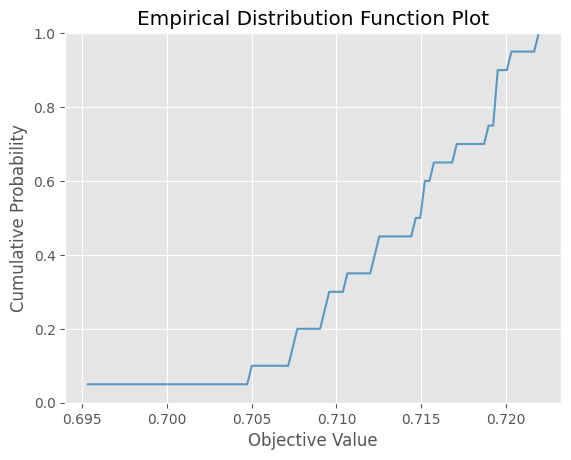

In [43]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [44]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = RandomForestClassifier(n_estimators=study.best_params["rf_n_estimators"], 
                                       criterion=study.best_params["rf_criterion"],
                                       max_depth=study.best_params["rf_max_depth"],
                                       min_samples_split=study.best_params["rf_min_samples_split"],
                                       max_features=study.best_params["rf_max_features"],
                                       min_samples_leaf=study.best_params["rf_min_samples_leaf"],
                                       random_state=42, 
                                       class_weight=study.best_params["rf_class_weight"])
        
        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [45]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", "Complete", X_train_t, y_train)

In [46]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [47]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [48]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "None",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [49]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])


prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                          
None              Random Forest 0.239               22             accuracy                0.792   
                                                                   balanced_accuracy       0.765   
                                                                   precision_macro         0.747   
                                                                   recall_macro            0.765   
                                                                   f1_macro                0.755   
                                                                   roc_auc_macro           0.927   
                                                                   specificity_macro       0.888   

                                                                                      Test data  \
Feature Selection Classifier    Classification Time Total Features Metric                         
None              Random Forest 0.239               22             accuracy               0.750   
                                                                   balanced_accuracy      0.714   
                                                                   precision_macro        0.707   
                                                                   recall_macro           0.714   
                                                                   f1_macro               0.709   
                                                                   roc_auc_macro          0.884   
                                                                   specificity_macro      0.865   

                                                                                              95% CI  \
Feature Selection Classifier    Classification Time Total Features Metric                              
None              Random Forest 0.239               22             accuracy           [0.707, 0.795]   
                                                                   balanced_accuracy  [0.667, 0.762]   
                                                                   precision_macro    [0.659, 0.752]   
                                                                   recall_macro       [0.662, 0.768]   
                                                                   f1_macro           [0.655, 0.758]   
                                                                   roc_auc_macro      [0.852, 0.911]   
                                                                   specificity_macro   [0.84, 0.889]   

                                                                                      Std Dev  
Feature Selection Classifier    Classification Time Total Features Metric                      
None              Random Forest 0.239               22             accuracy             0.022  
                                                                   balanced_accuracy    0.025  
                                                                   precision_macro      0.024  
                                                                   recall_macro         0.026  
                                                                   f1_macro             0.026  
                                                                   roc_auc_macro        0.015  
                                                                   specificity_macro    0.013

### Export model

In [50]:
trained_rf_n

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=None,
                       min_samples_leaf=0.023533046023203115,
                       min_samples_split=0.0892849084438209, n_estimators=208,
                       random_state=42)

In [51]:
import pickle

with open("rf_model.pkl", "wb") as file:
    pickle.dump(trained_rf_n, file)
    
print("Random Forest model saved successfully!")

Random Forest model saved successfully!
